# Computation of shape contour and area during growth of propagules.


##  Documentation and Imports


Created on 27-05-2021

Author: Valentin Laplaud

This code aims to compute the shape of propagules growing in microfluidic chips. It detects gemmae contours using binarization, and saves the data of the contour position on the image, as well as the area and geometrical center position of each gemmae. 

A second part fits the evolution of gemmae in time with a delayed exponential.

In [18]:
## Clean up before script start 

for element in dir():

    if element[0:1] != "_":

        del globals()[element]

import gc
gc.collect()


# plotting stuff
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline

COLOR = 'white'
COLOR2 = 'black'

mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR

mpl.rcParams["figure.facecolor"] = COLOR2
mpl.rcParams["axes.facecolor"] = COLOR2
mpl.rcParams["savefig.facecolor"] = COLOR2
mpl.rcParams['axes.facecolor'] = COLOR2

#Default colors
import matplotlib.pyplot as plt
from cycler import cycler
colorcycle = [plt.get_cmap('gist_rainbow')(1. * i/30) for i in range(30)]
mpl.rcParams['axes.prop_cycle'] = cycler(color=colorcycle)

# numbers handling
import numpy as np
import pandas as pd
from itertools import compress

# signal processing 
from scipy.signal import savgol_filter, correlate, correlation_lags
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit, least_squares

# images handling
from skimage import io
from skimage.filters import threshold_otsu, threshold_mean, gaussian, laplace, sobel
from skimage.measure import label, regionprops, regionprops_table
from skimage.util import invert
from skimage.morphology import binary_opening, binary_closing, remove_small_holes,binary_erosion, binary_dilation
from skimage.color import rgb2gray, rgb2hsv
from skimage.segmentation import active_contour
import cv2 as cv
import tifffile as tifff


# to hide known warnings
import warnings
warnings.filterwarnings("ignore")

# General system functions
import os
import shutil
import sys

import time

# my functions
sys.path.append('../PythonFunctions/')
import VallapFunc as vf
from GemmaeDetection import create_circular_mask, Binarize, BinarizeStack, getEdgeAndArea, GetContours
from AreaCurveFitting import 

##  Define analysis functions



#### Selection based on R2
Sort data based on the quality of the fit.

In [26]:
def selectR2s(GD, CD, Th, label, **kwargs):
    
    showHist = False
    print('Analyzing : ' + label)
    
    for key, value in kwargs.items(): 
        if key == 'showHist':
            showHist = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    R2sPos = ~np.isnan(GD['fitR2'].values)
    R2s = GD['fitR2'].values[R2sPos]
    goodR2s = R2s>=Th
    frac = np.round(sum(goodR2s)/len(goodR2s)*1000)/10
    
    StackList = GD.index[R2sPos].array.to_numpy()
    goodList = StackList[goodR2s]
    
    goodGD = GD.loc[goodList]
    goodCD = CD.loc[goodList]
    
    if showHist:
        
        
        fig, ax = plt.subplots(dpi=300)
        ax.set_title(label + '\n' + str(frac) + '% of data validated based on R2>' + str(Th))
        n, bins, patches = ax.hist(R2s, bins = np.arange(np.floor(min(R2s)*10)/10, 1.025, 0.025), color = 'r', rwidth = 0.95)
        xl = ax.get_xlim()
        yl = ax.get_ylim()
        ax.hist(R2s[goodR2s], bins = bins, color = 'g', rwidth = 0.95)
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        
        plt.show()
        
#     print('Validated data : ' + goodList + '\n\n' )

    return(goodGD, goodCD, R2s, goodList)

#### Comparing iterative fits
Accessory function to compare initial fit and final fit after iterations.

In [27]:
def compareFit(GD, label):
    
    ValuesPos = ~np.isnan(GD['tdeb'].values)
    
    Tdebs_inter1 = GD['tdeb_inter1'].values[ValuesPos]    
    Tdebs_inter2 = GD['tdeb_inter2'].values[ValuesPos]
    Tdebs = GD['tdeb'].values[ValuesPos]
    Tdebs_full = GD['tdeb_full'].values[ValuesPos]
    
    Taus_inter1 = GD['Tau_inter1'].values[ValuesPos]
    Taus_inter2 = GD['Tau_inter2'].values[ValuesPos]
    Taus = GD['Tau'].values[ValuesPos]
    Taus_full = GD['Tau_full'].values[ValuesPos]
    
    A0fits_inter1 = GD['A0fit_inter1'].values[ValuesPos]
    A0fits_inter2 = GD['A0fit_inter2'].values[ValuesPos]
    A0fits = GD['A0fit'].values[ValuesPos]
    A0fits_full = GD['A0fit_full'].values[ValuesPos]
    
    R2s_inter2 = GD['fitR2_inter2'].values[ValuesPos]
    R2s_inter1 = GD['fitR2_inter1'].values[ValuesPos]
    R2s = GD['fitR2'].values[ValuesPos]
    R2s_full = GD['fitR2_full'].values[ValuesPos]
    
    plotprops = {'color':'g'}
    flierprops = dict(marker='d', markerfacecolor='g', markersize=8,
                  markeredgecolor='none')
    
    plotprops_full = {'color':'r'}
    flierprops_full = dict(marker='d', markerfacecolor='r', markersize=8,
                  markeredgecolor='none')
   
    
    MIN = np.min([Tdebs_full, Tdebs, Tdebs_inter1, Tdebs_inter2])
    MAX = np.max([Tdebs_full, Tdebs, Tdebs_inter1, Tdebs_inter2])
    
    fig11, ax11 = plt.subplots(dpi=200)  
    ax11.set_title(label + ' - Tstart (min)')
    ax11.plot([MIN,MAX],[MIN,MAX],'-g')
    ax11.plot(Tdebs_full,Tdebs_inter1,'ro',ms = 5)
    ax11.plot(Tdebs_inter1,Tdebs_inter2,'mo',ms = 4.5)
    ax11.plot(Tdebs_inter2,Tdebs,'o',color=np.divide([150, 131, 236],255),ms = 4)
    ax11.set_xlabel('Previous fit')
    ax11.set_ylabel('Next fit')
    ax11.set_xlim(MIN-0.05*MAX,MAX*1.05)
    ax11.set_ylim(MIN-0.05*MAX,MAX*1.05)
    
    
    MIN = np.min([Taus_full, Taus, Taus_inter1, Taus_inter2])
    MAX = np.max([Taus_full, Taus, Taus_inter1, Taus_inter2])

    fig21, ax21 = plt.subplots(dpi=200)  
    ax21.set_title(label + ' - Tau growth (hours)')
    ax21.plot([MIN,MAX],[MIN,MAX],'-g')
    ax21.plot(Taus_full,Taus_inter1,'ro',ms = 5)
    ax21.plot(Taus_inter1,Taus_inter2,'mo',ms = 4.5)
    ax21.plot(Taus_inter2,Taus,'o',color=np.divide([150, 131, 236],255),ms = 4)
    ax21.set_xlabel('Previous fit')
    ax21.set_ylabel('Next fit')
    ax21.set_xlim(MIN-0.05*MAX,MAX*1.05)
    ax21.set_ylim(MIN-0.05*MAX,MAX*1.05)
    
    
    MIN = np.min([A0fits_full, A0fits, A0fits_inter1, A0fits_inter2])
    MAX = np.max([A0fits_full, A0fits, A0fits_inter1, A0fits_inter2])

    fig31, ax31 = plt.subplots(dpi=200)  
    ax31.set_title(label + ' - A0fit (mm²)')
    ax31.plot([MIN,MAX],[MIN,MAX],'-g')
    ax31.plot(A0fits_full,A0fits_inter1,'ro',ms = 5)
    ax31.plot(A0fits_inter1,A0fits_inter2,'mo',ms = 4.5)
    ax31.plot(A0fits_inter2,A0fits,'o',color=np.divide([150, 131, 236],255),ms = 4)
    ax31.set_xlabel('Previous fit')
    ax31.set_ylabel('Next fit')
    ax31.set_xlim(MIN-0.05*MAX,MAX*1.05)
    ax31.set_ylim(MIN-0.05*MAX,MAX*1.05)
    
  
    
    return

### Fit of osmotic choc curve

#### Selection based on R2 for relaxation

In [28]:
def selectR2s_OC_Rel(GD, CD, Th, label, **kwargs):
    
    showHist = False
    print('Analyzing : ' + label)
    
    for key, value in kwargs.items(): 
        if key == 'showHist':
            showHist = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    R2sPos = ~np.isnan(GD['fitR2rel'].values)
    R2s = GD['fitR2rel'].values[R2sPos]
    goodR2s = R2s>=Th
    frac = np.round(sum(goodR2s)/len(goodR2s)*1000)/10
    
    StackList = GD.index[R2sPos].array.to_numpy()
    goodList = StackList[goodR2s]
    
    goodGD = GD.loc[goodList]
    goodCD = CD.loc[goodList]
    
    if showHist:
        
        
        fig, ax = plt.subplots(dpi=300)
        ax.set_title(label + '\n' + str(frac) + '% of data validated based on R2>' + str(Th))
        n, bins, patches = ax.hist(R2s, bins = np.arange(np.floor(min(R2s)*10)/10, 1.025, 0.025), color = 'r', rwidth = 0.95)
        xl = ax.get_xlim()
        yl = ax.get_ylim()
        ax.hist(R2s[goodR2s], bins = bins, color = 'g', rwidth = 0.95)
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        
        plt.show()
        
#     print('Validated data : ' + goodList + '\n\n' )

    return(goodGD, goodCD, R2s, goodList)

#### Curve sorting based on AR change in flux direction

In [29]:
def sortChocs(CD,GD,StackList,ImgStart,ImgEq,Plots):

    nppg = len(StackList)
    GoodStacks = []
    AR = []


    for s in StackList:  

        AR.append(
            np.max(
                np.abs(
                    np.divide(
                        np.divide(GD.loc[s,'Ylength'].values[ImgStart:ImgEq-1],
                                  GD.loc[s,'Xlength'].values[ImgStart:ImgEq-1]),
                        np.divide(GD.loc[s,'Ylength'].values[ImgStart],
                                  GD.loc[s,'Xlength'].values[ImgStart]))-1
                )
            )
        )

    GoodStacks = list(compress(StackList,AR<2*np.quantile(AR,[0.75])))

    
    if Plots:
        f1,ax1 = plt.subplots(dpi=250,figsize=(5,3.5))
        f2,ax2 = plt.subplots(dpi=250,figsize=(5,3.5)) 

        for s in StackList:
            if s in GoodStacks:
                ax1.plot(GD.loc[s,'Img'].values[ImgStart:ImgEq]/2,GD.loc[s,'Area'].values[ImgStart:ImgEq]/GD.loc[s,'Area'].values[ImgStart],
                         'g-',lw=0.3,zorder=0)
                ax2.plot(GD.loc[s,'Img'].values[ImgStart:ImgEq]/2,(GD.loc[s,'Ylength'].values[ImgStart:ImgEq]/GD.loc[s,'Xlength'].values[ImgStart:ImgEq])/
                      (GD.loc[s,'Ylength'].values[ImgStart]/GD.loc[s,'Xlength'].values[ImgStart])-1,'g-',zorder=0,lw=0.3)
            else:            
                ax1.plot(GD.loc[s,'Img'].values[ImgStart:ImgEq]/2,GD.loc[s,'Area'].values[ImgStart:ImgEq]/GD.loc[s,'Area'].values[ImgStart],'r-',
                         lw=0.3,zorder=1)
                ax2.plot(GD.loc[s,'Img'].values[ImgStart:ImgEq]/2,(GD.loc[s,'Ylength'].values[ImgStart:ImgEq]/GD.loc[s,'Xlength'].values[ImgStart:ImgEq])/
                      (GD.loc[s,'Ylength'].values[ImgStart]/GD.loc[s,'Xlength'].values[ImgStart])-1,'r-',lw=0.3,zorder=1)


        plt.show()
    print('Kept ' + str(len(GoodStacks)) + '/' + str(nppg) + 'PPGs (' + str(np.round(len(GoodStacks)/nppg*10000)/100) + '%)' )

    return(CD.loc[GoodStacks],GD.loc[GoodStacks],GoodStacks)

#### Fit functions

#### Fitting data

In [32]:
def fitOsmoChoc(StackList,CD,GD,FPH,ImgStartComp,ImgEqComp,ImgStartRel,ImgEqRel, **kwargs):
    
    DebugPlots = False
    
    for key, value in kwargs.items(): 
        if key == 'debug':
            DebugPlots = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    print('Sorting data.')
    CD,GD,StackList = sortChocs(CD,GD,StackList,ImgStartComp,ImgEqComp,DebugPlots)    
    CDrel,GDrel,StackListRel = sortChocs(CD,GD,StackList,ImgStartRel,ImgEqRel,DebugPlots)        
    
    for s in StackList:

        print('Fitting curve for : ' + s.ljust(5), end='\n')           
        
        Time = GD.loc[s,'Img'].values.astype(float)/FPH*60 # in minutes
        AreaC = GD.loc[s,'Area'].values
        
        
        # data for compression fit
        TimeFitComp = GD.loc[s,'Img'].values.astype(float)[ImgStartComp:ImgEqComp]/FPH*60 # in minutes
        TimeOffset = TimeFitComp[0]
        Time = Time - TimeOffset
        TimeFitComp = TimeFitComp - TimeOffset
        AreaCFitComp = GD.loc[s,'Area'].values[ImgStartComp:ImgEqComp]
               
        fig,ax = plt.subplots(dpi=300)
        ax.plot(Time,AreaC,'*y',ms=3,label='FullData')
        ax.set_xlabel('Time (min)')
        ax.set_ylabel('Area (mm²)')

        DenseTimeComp = np.linspace(TimeFitComp[0],TimeFitComp[-1],100)

        # fit of compression
        params, cov = curve_fit(f=fitFuncOsmChoc, xdata=TimeFitComp, ydata=AreaCFitComp, 
                                p0=[1, AreaCFitComp[0],AreaCFitComp[0],TimeFitComp[3]],
                                bounds = (0, np.inf), method='trf',loss='soft_l1')

        R2 = np.round(vf.computeR2(AreaCFitComp,fitFuncOsmChoc(TimeFitComp,params[0],params[1],params[2],params[3]))*1000)/1000

        fig.suptitle(s + ' - R2 : ' + str(R2))
        
        # Physical parameters
        DeltaPiOut = 8.314*293*100/1e6 # en MPa, R (gaz parfait) * Temp (K, 20°) * 0.1 (100mM = 100 mol/m3 de choc)
        
        E = params[1]/(params[1]-params[2])*DeltaPiOut # en MPa
        Lh = 1/(params[0]*60*E*1e6) # en m/s/Pa
        
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'TauFlux'] = params[0] 
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'V0'] = params[1] 
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'Veq'] = params[2]   
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'V0-Veq'] = params[1]-params[2]        
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'E'] = E             
        GD.loc[(GD.index == s) & (GD['Img'] == 0), '1/E'] = 1/E       
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'L/H'] = Lh 
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'H/L'] = 1/Lh
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'Tdeb'] = params[3]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'tdebShift'] = np.argmin(np.abs(Time-params[3])) # img shift for alignemen
        
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'fitR2'] = R2
        
        ax.plot(TimeFitComp,AreaCFitComp,'*c',ms=2.5,label='FittedData')
        ax.plot(DenseTimeComp,fitFuncOsmChoc(DenseTimeComp,params[0],params[1],params[2],params[3]),'--b',lw=1,label='SoftL1')
        
        # Relaxation fit if valid data
        if np.isin(s,StackListRel):
            TimeFitRel = GD.loc[s,'Img'].values.astype(float)[ImgStartRel:ImgEqRel]/FPH*60 # in minutes
            TimeFitRel = TimeFitRel - TimeOffset
            AreaCFitRel = GD.loc[s,'Area'].values[ImgStartRel:ImgEqRel]

            DenseTimeRel = np.linspace(TimeFitRel[0],TimeFitRel[-1],100)

            # first fit to determine tdeb
            paramsRel, covRel = curve_fit(f=fitFuncOsmChoc2, xdata=TimeFitRel, ydata=AreaCFitRel,
                                          p0=[params[0] , params[2],params[1],TimeFitRel[3],0.0005],
                                          bounds = (0, np.inf), method='trf',loss='soft_l1')

            
            R2rel = np.round(vf.computeR2(AreaCFitRel,
                    fitFuncOsmChoc2(TimeFitRel,paramsRel[0],paramsRel[1],paramsRel[2],paramsRel[3],paramsRel[4]))*1000)/1000
            

            fig.suptitle(s + ' - R2Comp : ' + str(R2) + ' - R2Rel : ' + str(R2rel))

            Erel = paramsRel[2]/(paramsRel[2]-paramsRel[1])*DeltaPiOut # en MPa
            LhRel = 1/(paramsRel[0]*60*Erel*1e6) # en m/s/Pa

            GD.loc[(GD.index == s) & (GD['Img'] == 0), 'TauFluxRel'] = paramsRel[0] 
            GD.loc[(GD.index == s) & (GD['Img'] == 0), 'V0Rel'] = paramsRel[2] 
            GD.loc[(GD.index == s) & (GD['Img'] == 0), 'VeqRel'] = paramsRel[1]   
            GD.loc[(GD.index == s) & (GD['Img'] == 0), 'V0Rel-VeqRel'] = paramsRel[2]-paramsRel[1]        
            GD.loc[(GD.index == s) & (GD['Img'] == 0), 'Erel'] = Erel            
            GD.loc[(GD.index == s) & (GD['Img'] == 0), '1/Erel'] = 1/Erel     
            GD.loc[(GD.index == s) & (GD['Img'] == 0), 'L/H_Rel'] = LhRel 
            GD.loc[(GD.index == s) & (GD['Img'] == 0), 'H/L_Rel'] = 1/LhRel
            GD.loc[(GD.index == s) & (GD['Img'] == 0), 'TdebRel'] = paramsRel[3]

            GD.loc[(GD.index == s) & (GD['Img'] == 0), 'fitR2rel'] = R2rel


            ax.plot(TimeFitRel,AreaCFitRel,'*m',ms=2.5,label='FittedDataRel')
            ax.plot(DenseTimeRel,fitFuncOsmChoc2(DenseTimeRel,paramsRel[0],paramsRel[1],paramsRel[2],paramsRel[3],paramsRel[4]),'--r',lw=1,label='SoftL1')
        

        fig.tight_layout()
        
        if DebugPlots:
            plt.show()
        else:
            plt.close(fig)
        
        
    
    return(GD)

### Wrapper functions

#### Area growth 

In [33]:
def BinarizeAndFitArea(stringName,StackList,Path,Scale,FPH,Delay,R2Threshold,ToDo, **kwargs):
    
    showHist = False
    DebugPlots = False
    HSVrange = [(25, 25, 70),(60, 120,220)]
    ImgList = [0, 20, 40]
    fitwindow=15
    
    for key, value in kwargs.items(): 
        if key == 'showHist':
            showHist = value
        elif key == 'debug':
            DebugPlots = value
        elif key == 'debuglist':
            ImgList = value 
        elif key == 'HSVrange':
            HSVrange = value
        elif key == 'fitwindow':
            fitwindow = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    if ToDo == 'BCF':
        DoBin = True
        DoCont = True
        DoFit = True
    elif ToDo == 'B':
        DoBin = True
        DoCont = False
        DoFit = False
    elif ToDo == 'CF':
        DoBin = False
        DoCont = True
        DoFit = True
    elif ToDo == 'F':
        DoBin = False
        DoCont = False
        DoFit = True
    else:
        raise NameError('ToDo variable is wrong')
    
    print('\n\n\n' + stringName + '\n\n')
    
    # Binarization of stacks
    if DoBin:
        BinarizeStack(StackList, Path, Scale,debug = DebugPlots, HSVrange = HSVrange, debuglist = ImgList)
    
    if DoCont:
                
        # Computing contours from binary
        CD,GD = GetContours(StackList,Path, Scale,FPH, debug=DebugPlots)

        # Saving all contours
        GD.to_csv(Path + '\\GlobalData' + stringName + '_AreaCont.csv',index_label = 'Ind')
        CD.to_csv(Path + '\\ContourData' + stringName + '_AreaCont.csv',index_label = 'Ind')

    if DoFit:
        
        GD = pd.read_csv(Path + '\\GlobalData' + stringName + '_AreaCont.csv', index_col = 'Ind')
        CD = pd.read_csv(Path + '\\ContourData' + stringName + '_AreaCont.csv',index_col = 'Ind')
        
        # Retrieve data on PPG position in chip        
        posinchip = pd.read_excel (Path + '\ChipPositions.xlsx', index_col='Name')        
        Rows = posinchip.loc[StackList].values[:,0]
        
        # Fitting area growth
        GD = fitAreaGrowth(StackList,Rows,GD,FPH,Delay, debug = DebugPlots,fitwindow = fitwindow)

        # Sorting based on fit quality
        GD, CD, R2s, goodList = selectR2s(GD,CD,R2Threshold,stringName, showHist = showHist)

        # Fit convergence 
        compareFit(GD, stringName)
        
        # Saving sorted contour and fit data
        GD.to_csv(Path + '\\GlobalData' + stringName + '_AreaFit.csv',index_label = 'Ind')
        CD.to_csv(Path + '\\ContourData' + stringName + '_AreaFit.csv',index_label = 'Ind')
    
    return

#### Osmotic choc

In [34]:
def BinarizeAndFitOsChoc(stringName,StackList,Path,Scale,FPH,R2Threshold,ToDo, **kwargs):
    
    showHist = False
    DebugPlots = False
    HSVrange = [(25, 25, 70),(60, 120,220)]
    ImgList = [0, 20, 40]
    FitIntervalComp = [2,25]
    FitIntervalRel = [29,55]
    
    for key, value in kwargs.items(): 
        if key == 'showHist':
            showHist = value
        elif key == 'debug':
            DebugPlots = value
        elif key == 'debuglist':
            ImgList = value 
        elif key == 'HSVrange':
            HSVrange = value
        elif key == 'FitIntervalComp':
            FitIntervalComp = value
        elif key == 'FitIntervalRel':
            FitIntervalRel = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    if ToDo == 'BCF':
        DoBin = True
        DoCont = True
        DoFit = True
    elif ToDo == 'B':
        DoBin = True
        DoCont = False
        DoFit = False
    elif ToDo == 'CF':
        DoBin = False
        DoCont = True
        DoFit = True
    elif ToDo == 'F':
        DoBin = False
        DoCont = False
        DoFit = True
    else:
        raise NameError('ToDo variable is wrong')
    
    print('\n\n\n' + stringName + '\n\n')
    
    # Binarization of stacks
    if DoBin:
        BinarizeStack(StackList, Path, Scale,debug = DebugPlots, HSVrange = HSVrange, debuglist = ImgList)
    
    if DoCont:
                
        # Computing contours from binary
        CD,GD = GetContours(StackList,Path, Scale,FPH, debug=DebugPlots)
        
        # Saving all contours
        GD.to_csv(Path + '\\GlobalData' + stringName + '_AreaCont.csv',index_label = 'Ind')
        CD.to_csv(Path + '\\ContourData' + stringName + '_AreaCont.csv',index_label = 'Ind')
        
        print('Contour saved')

    if DoFit:
        
        GD = pd.read_csv(Path + '\\GlobalData' + stringName + '_AreaCont.csv', index_col = 'Ind')
        CD = pd.read_csv(Path + '\\ContourData' + stringName + '_AreaCont.csv',index_col = 'Ind')
        
        GD = fitOsmoChoc(StackList,CD,GD,FPH,FitIntervalComp[0],FitIntervalComp[1],FitIntervalRel[0],FitIntervalRel[1],debug = DebugPlots)
        
        GD, CD, R2s, goodList = selectR2s(GD, CD, R2Threshold, stringName,showHist=showHist)
        GD, CD, R2s, goodList = selectR2s_OC_Rel(GD, CD, R2Threshold, stringName,showHist=showHist)
        
        # Saving sorted contour and fit data
        GD.to_csv(Path + '\\GlobalData' + stringName + '_AreaFit.csv',index_label = 'Ind')
        CD.to_csv(Path + '\\ContourData' + stringName + '_AreaFit.csv',index_label = 'Ind')
    
    return

## Enter data and run



### Data details

In [35]:
%run D:/Users/laplaud/Desktop/PostDoc/Code/JupyterNB/ExperimentList.py

Data choice made.


### Run

#### Flux controls V5 (03/27-09-2021)

In [36]:
# BinarizeAndFitArea('210903_1mlh',StackList210903_1,P210903_1,Scale210903,FPH210903,Delay210903,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

# BinarizeAndFitArea('210903_500ulh',StackList210903_5,P210903_5,Scale210903,FPH210903,Delay210903,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])



# BinarizeAndFitArea('210927_1mlh',StackList210927_1,P210927_1,Scale210927,FPH210927,Delay210927,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

# BinarizeAndFitArea('210927_500ulh',StackList210927_5,P210927_5,Scale210927,FPH210927,Delay210927,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

#### Manitol 125mM V5 (14-09-2021)

In [37]:
# BinarizeAndFitArea('210914_Ct',StackList210914_Ct,P210914_Ct,Scale210914,FPH210914,Delay210914,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

# BinarizeAndFitArea('210914_M125',StackList210914_M125,P210914_M125,Scale210914,FPH210914,Delay210914,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

#### System control DV6 (22-10-2021)

In [38]:
# BinarizeAndFitArea('211022_Ct1',StackList211022_Ct1,P211022_Ct1,Scale211022,FPH211022,Delay211022,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

# BinarizeAndFitArea('211022_Ct2',StackList211022_Ct2,P211022_Ct2,Scale211022,FPH211022,Delay211022,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

#### Degas & BSA controls DV6 (05-11-2021, 22-12-2021)

In [39]:
# BinarizeAndFitArea('211105_Deg_Bsa',StackList211105_Deg_Bsa,P211105_Deg_Bsa,Scale211105,FPH211105,Delay211105,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 20, 70),(60, 120,220)])

# BinarizeAndFitArea('211105_Degas',StackList211105_Degas,P211105_Degas,Scale211105,FPH211105,Delay211105,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 20, 70),(60, 120,220)])



# BinarizeAndFitArea('211222_Deg_Bsa',StackList211222_Deg_Bsa,P211222_Deg_Bsa,Scale211222,FPH211222,Delay211222,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

# BinarizeAndFitArea('211222_Degas',StackList211222_Degas,P211222_Degas,Scale211222,FPH211222,Delay211222,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

#### Stade comparison DV6 (07/12/14-01-2022)

In [40]:
# BinarizeAndFitArea('220107_S1',StackList220107_S1,P220107_S1,Scale220107,FPH220107,Delay220107,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(25, 30, 70),(60, 120,220)])

# BinarizeAndFitArea('220107_S3',StackList220107_S3,P220107_S3,Scale220107,FPH220107,Delay220107,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(25, 30, 70),(60, 120,220)])



# BinarizeAndFitArea('220112_S1',StackList220112_S1,P220112_S1,Scale220112,FPH220112,Delay220112,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(20, 30, 70),(60, 120,220)])

# BinarizeAndFitArea('220112_S3',StackList220112_S3,P220112_S3,Scale220112,FPH220112,Delay220112,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(20, 30, 70),(60, 120,220)])



# BinarizeAndFitArea('220114_S1',StackList220114_S1,P220114_S1,Scale220114,FPH220114,Delay220114,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(25, 25, 70),(60, 120,220)])

# BinarizeAndFitArea('220114_S3',StackList220114_S3,P220114_S3,Scale220114,FPH220114,Delay220114,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(25, 25, 70),(60, 120,220)])

#### System controls with Stade1 & degas DV6 (24-01-2022,03/13-02-2022)

In [41]:
# BinarizeAndFitArea('220124_Ct1',StackList220124_Ct1,P220124_Ct1,Scale220124,FPH220124,Delay220124,0.95,'F',
#                    showHist = True, debug = False, HSVrange =[(15, 17, 60),(70, 120,220)],fitwindow=10)

# BinarizeAndFitArea('220124_Ct2',StackList220124_Ct2,P220124_Ct2,Scale220124,FPH220124,Delay220124,0.95,'F',
#                     showHist = True, debug = False, HSVrange =[(15, 17, 60),(70, 120,220)],fitwindow=10)

# BinarizeAndFitArea('220203_Ct1',StackList220203_Ct1,P220203_Ct1,Scale220203,FPH220203,Delay220203,0.95,'F',
#                    showHist = True, debug = False, HSVrange =[(15, 17, 60),(70, 120,220)])

# BinarizeAndFitArea('220203_Ct2',StackList220203_Ct2,P220203_Ct2,Scale220203,FPH220203,Delay220203,0.95,'F',
#                     showHist = True, debug = False, HSVrange =[(15, 17, 60),(70, 140,220)])

# BinarizeAndFitArea('220214_Ct1',StackList220214_Ct1,P220214_Ct1,Scale220214,FPH220214,Delay220214,0.98,'F',
#                    showHist = False, debug = False, HSVrange =[(15, 30, 60),(70, 120,220)],fitwindow=10)

# BinarizeAndFitArea('220214_Ct2',StackList220214_Ct2,P220214_Ct2,Scale220214,FPH220214,Delay220214,0.98,'F',
#                    showHist = False, debug = False, HSVrange =[(15, 30, 60),(70, 140,220)],fitwindow=10)

#### Osmotic choc after 14-02-2022 

In [42]:
# BinarizeAndFitOsChoc('220214_Ct1_Osmo',StackList220214_Ct1_Osmo,P220214_Ct1_Osmo,Scale220214_Osmo,FPH220214_Osmo,0.98,'F',
#                    showHist = True, debug = False, HSVrange =[(15, 30, 60),(70, 140,220)],FitIntervalComp = [0,25],
#                      FitIntervalRel = [26,60])

# BinarizeAndFitOsChoc('220214_Ct2_Osmo',StackList220214_Ct2_Osmo,P220214_Ct2_Osmo,Scale220214_Osmo,FPH220214_Osmo,0.98,'F',
#                    showHist = True, debug = False, HSVrange =[(15, 30, 60),(70, 140,220)],FitIntervalComp = [0,25],
#                      FitIntervalRel = [27,60])


#### Manitol 100mM (01-03-2022) + OC

In [43]:
# BinarizeAndFitArea('220301_Ct',StackList220301_Ct,P220301_Ct,Scale220301,FPH220301,Delay220301,0.9,'F',
#                    showHist = False, debug = False, debuglist = [0], HSVrange =[(15, 17, 60),(70, 140,220)])
# BinarizeAndFitOsChoc('220301_Ct_Osmo',StackList220301_Ct_Osmo,P220301_Ct_Osmo,Scale220301_Osmo,FPH220301_Osmo,0.95,'F',
#                    showHist = False, debug = False, debuglist = [0], HSVrange =[(15, 17, 60),(70, 140,220)],FitInterval = [0,30])

# BinarizeAndFitArea('220301_M100',StackList220301_M100,P220301_M100,Scale220301,FPH220301,Delay220301,0.9,'F',
#                    showHist = False, debug = False, debuglist = [0], HSVrange =[(15, 17, 60),(70, 140,220)])
# BinarizeAndFitOsChoc('220301_M100_Osmo',StackList220301_M100_Osmo,P220301_M100_Osmo,Scale220301_Osmo,FPH220301_Osmo,0.95,'F',
#                    showHist = False, debug = False, debuglist = [0], HSVrange =[(15, 17, 60),(70, 140,220)],FitInterval = [0,30])

#### Ctrls DV6 +OC (05/04/22)

In [44]:
# BinarizeAndFitArea('220405_Ct1',StackList220405_Ct1,P220405_Ct1,Scale220405,FPH220405,Delay220405,0.95,'BCF',
#                    showHist = True, debug = False, debuglist = [0,10,23,38],HSVrange =[(15, 15, 60),(70, 120,220)])

# BinarizeAndFitArea('220405_Ct2',StackList220405_Ct2,P220405_Ct2,Scale220405,FPH220405,Delay220405,0.95,'B',
#                    showHist = True, debug = False, HSVrange =[(15, 30, 60),(70, 140,220)])

# BinarizeAndFitOsChoc('220405_Ct1_Osmo',StackList220405_Ct1_Osmo,P220405_Ct1_Osmo,Scale220405_Osmo,FPH220405_Osmo,0.95,'BCF',
#                    showHist = True, debug = False, debuglist = [0,10,23,38], HSVrange =[(15, 25, 60),(70, 140,220)],FitInterval = [0,25])


# BinarizeAndFitOsChoc('220405_Ct2_Osmo',StackList220405_Ct2_Osmo,P220405_Ct2_Osmo,Scale220405_Osmo,FPH220405_Osmo,0.95,'B',
#                    showHist = False, debug = True, HSVrange =[(15, 30, 60),(70, 140,220)],FitInterval = [0,25])


#### Ctrls DV7 + OC100 (31/05/22)




220531_Ct1


Processing PPG1 :


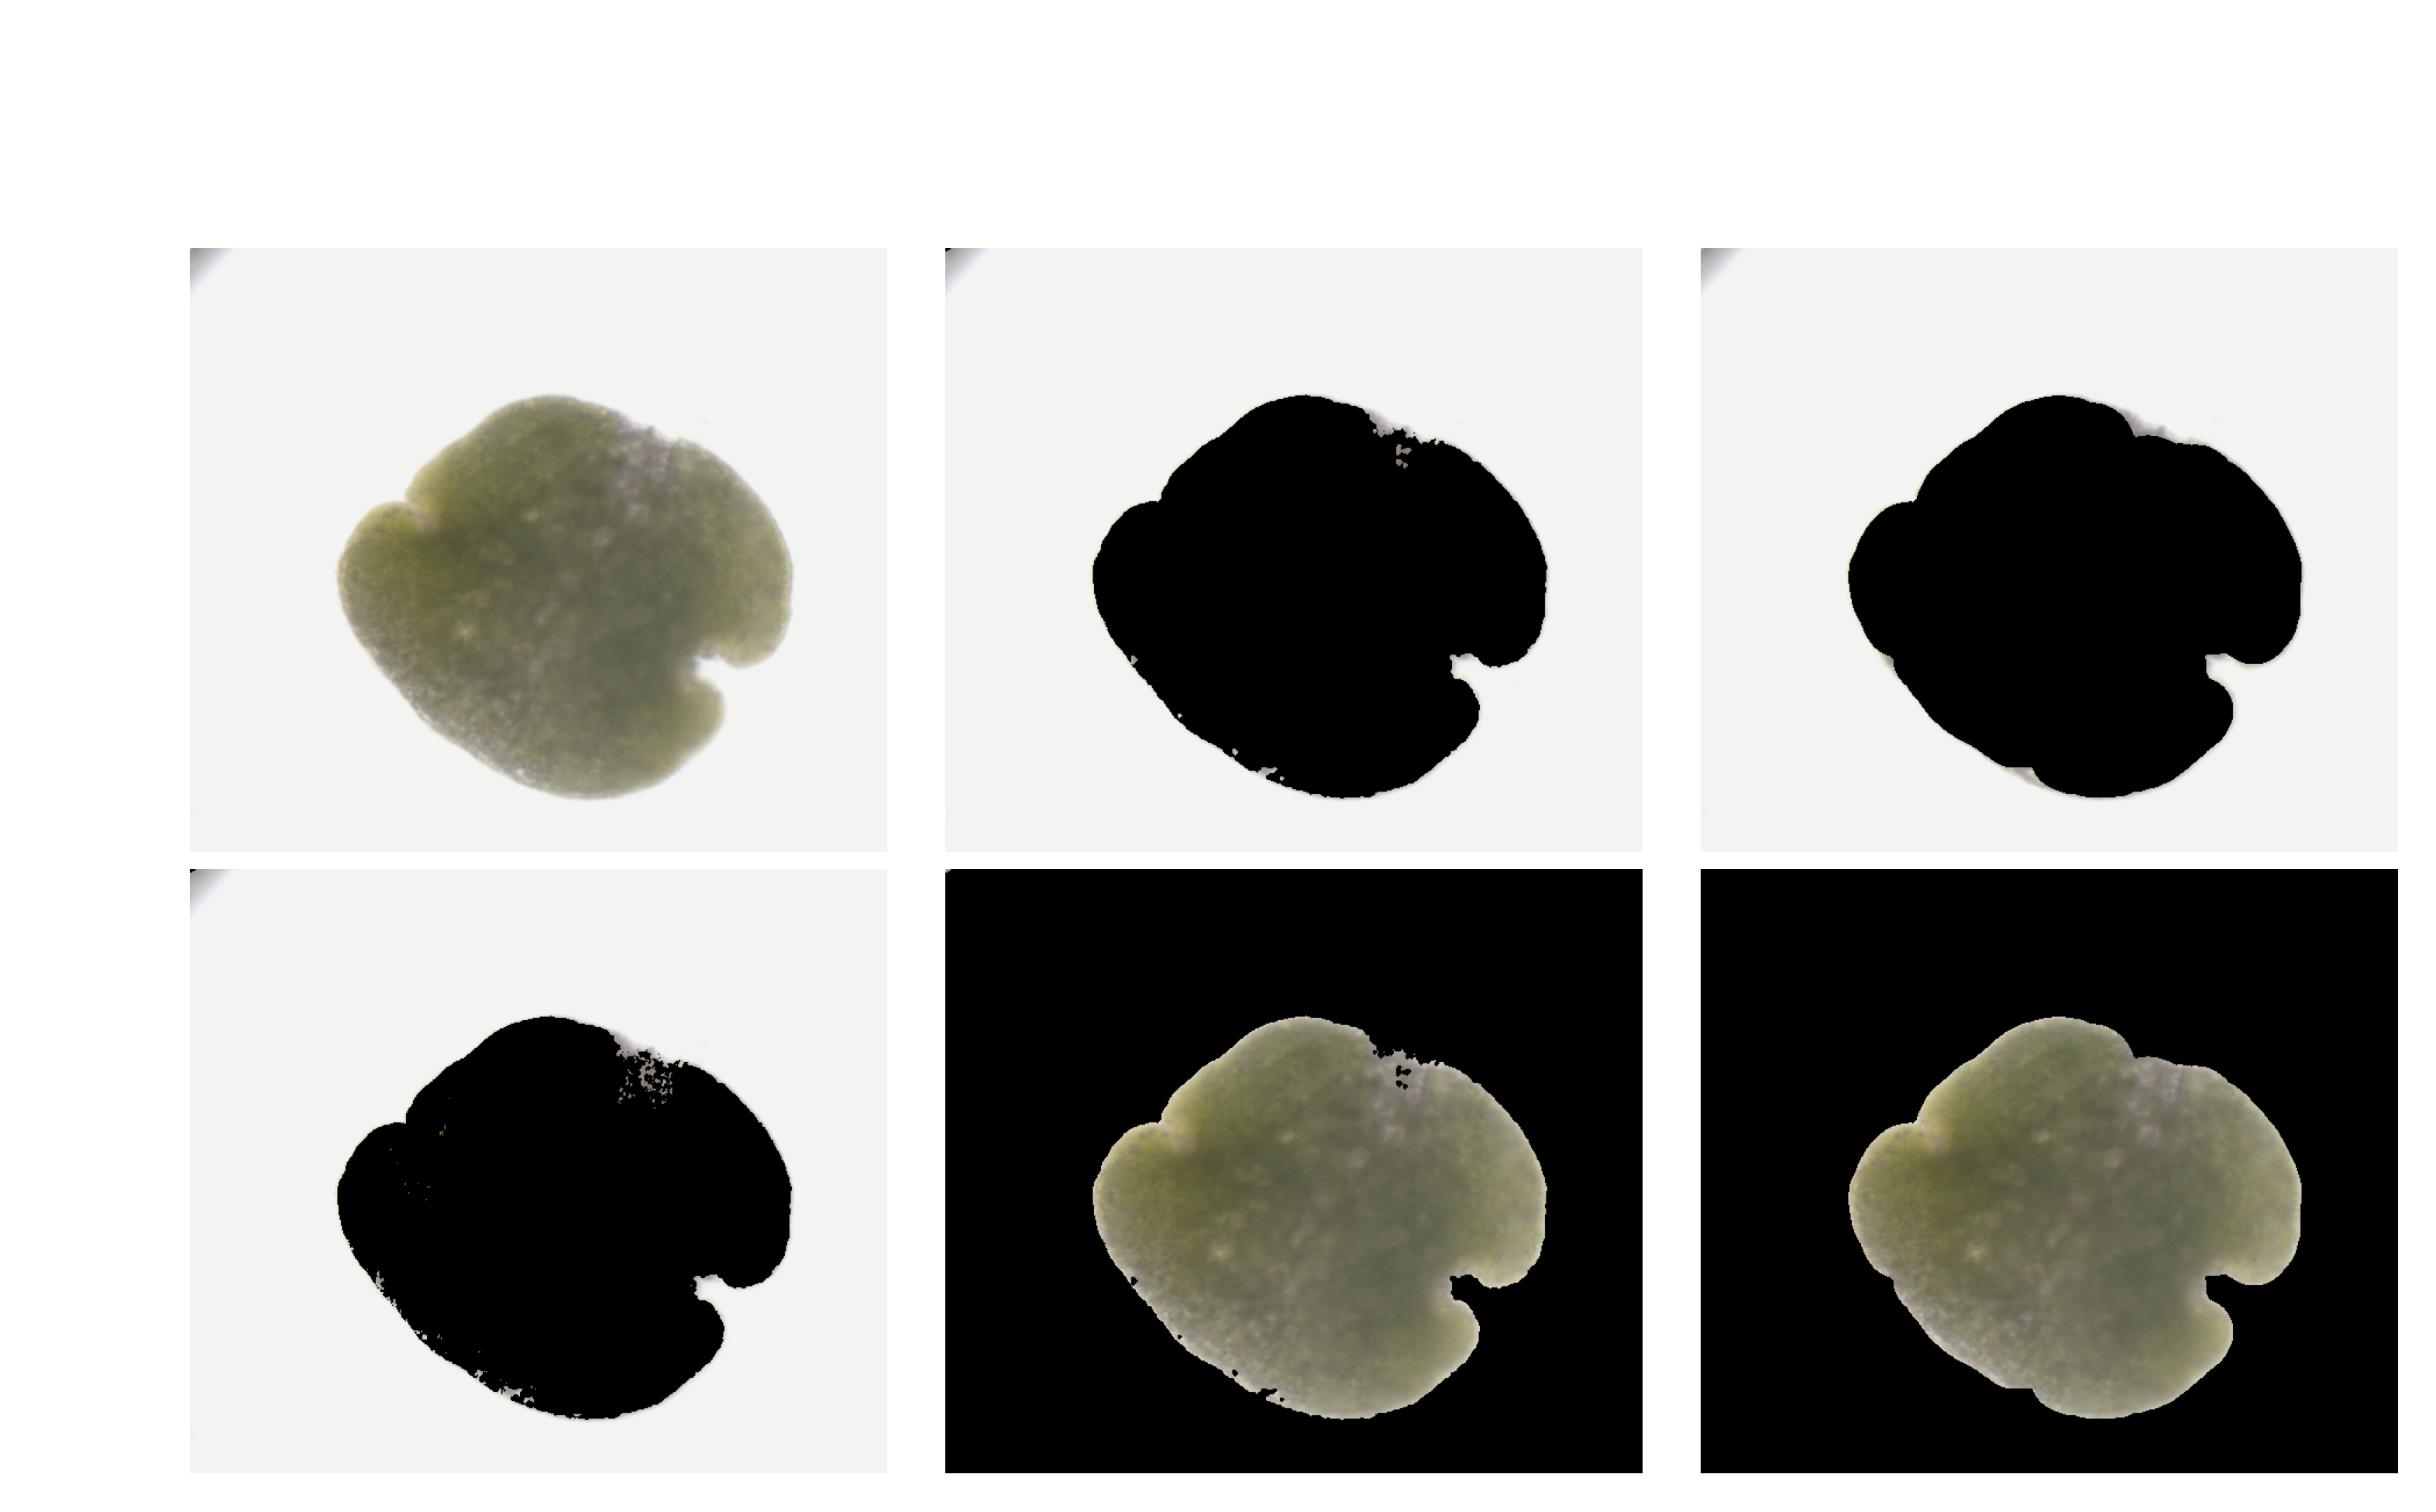

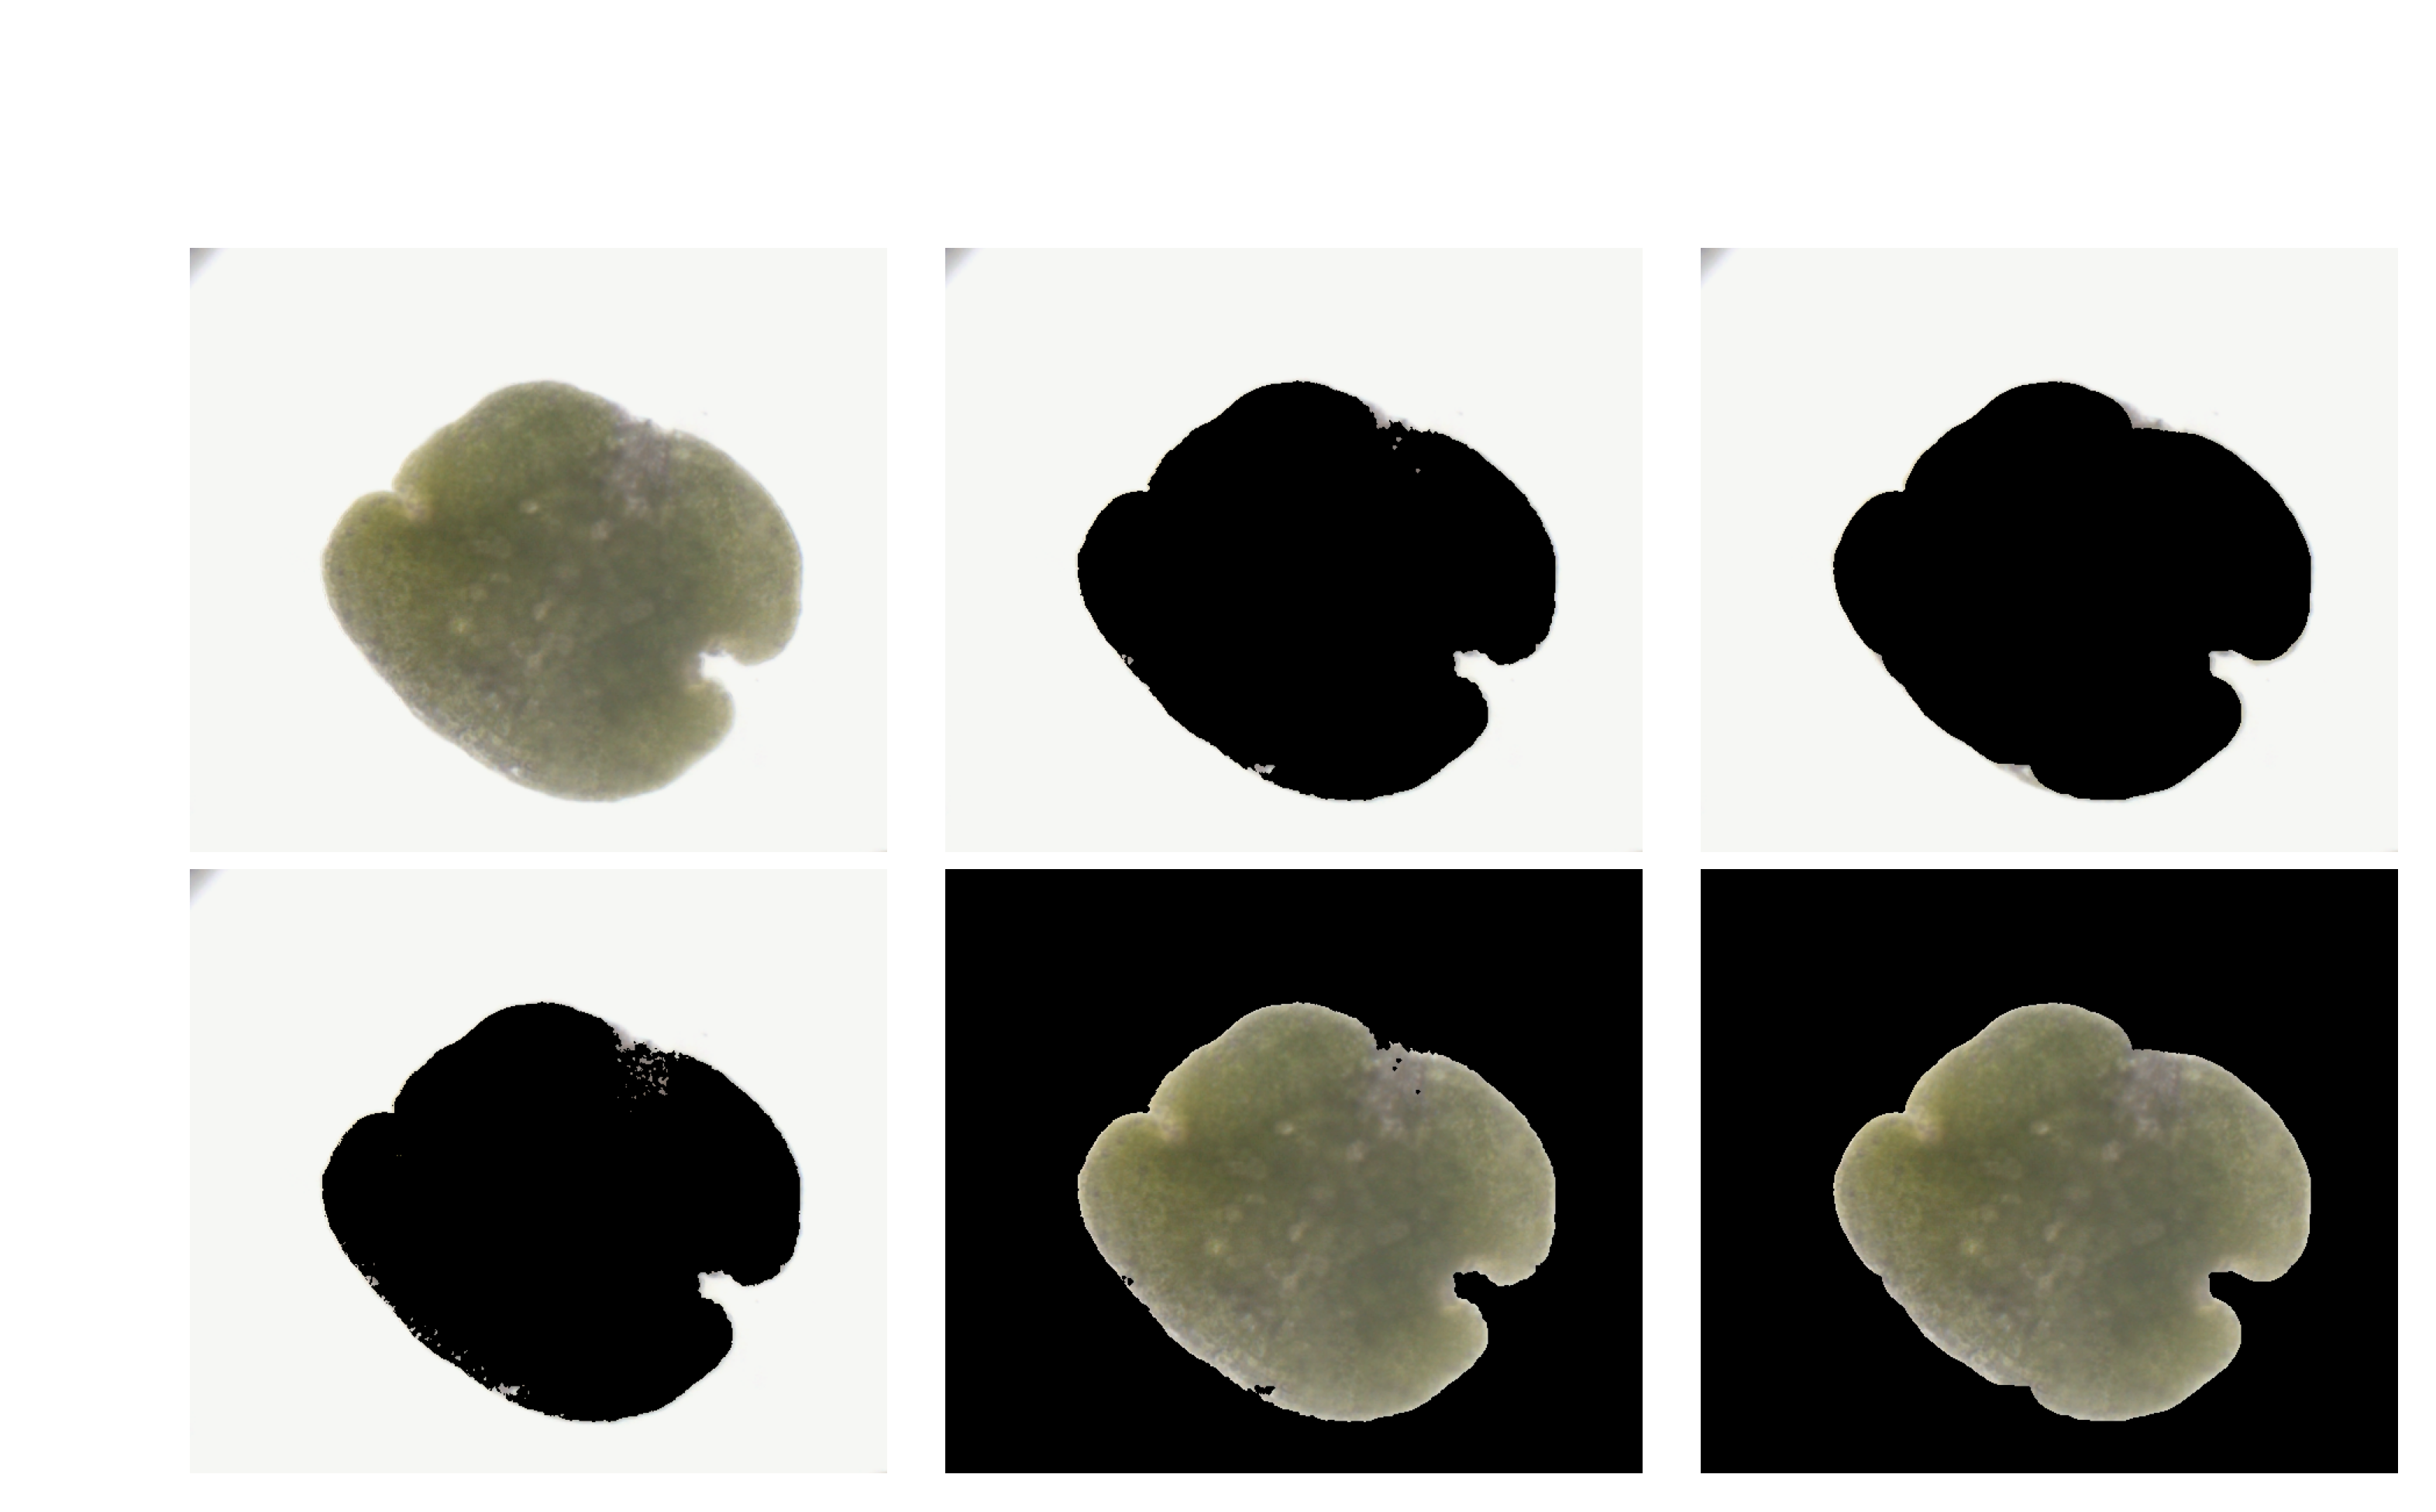

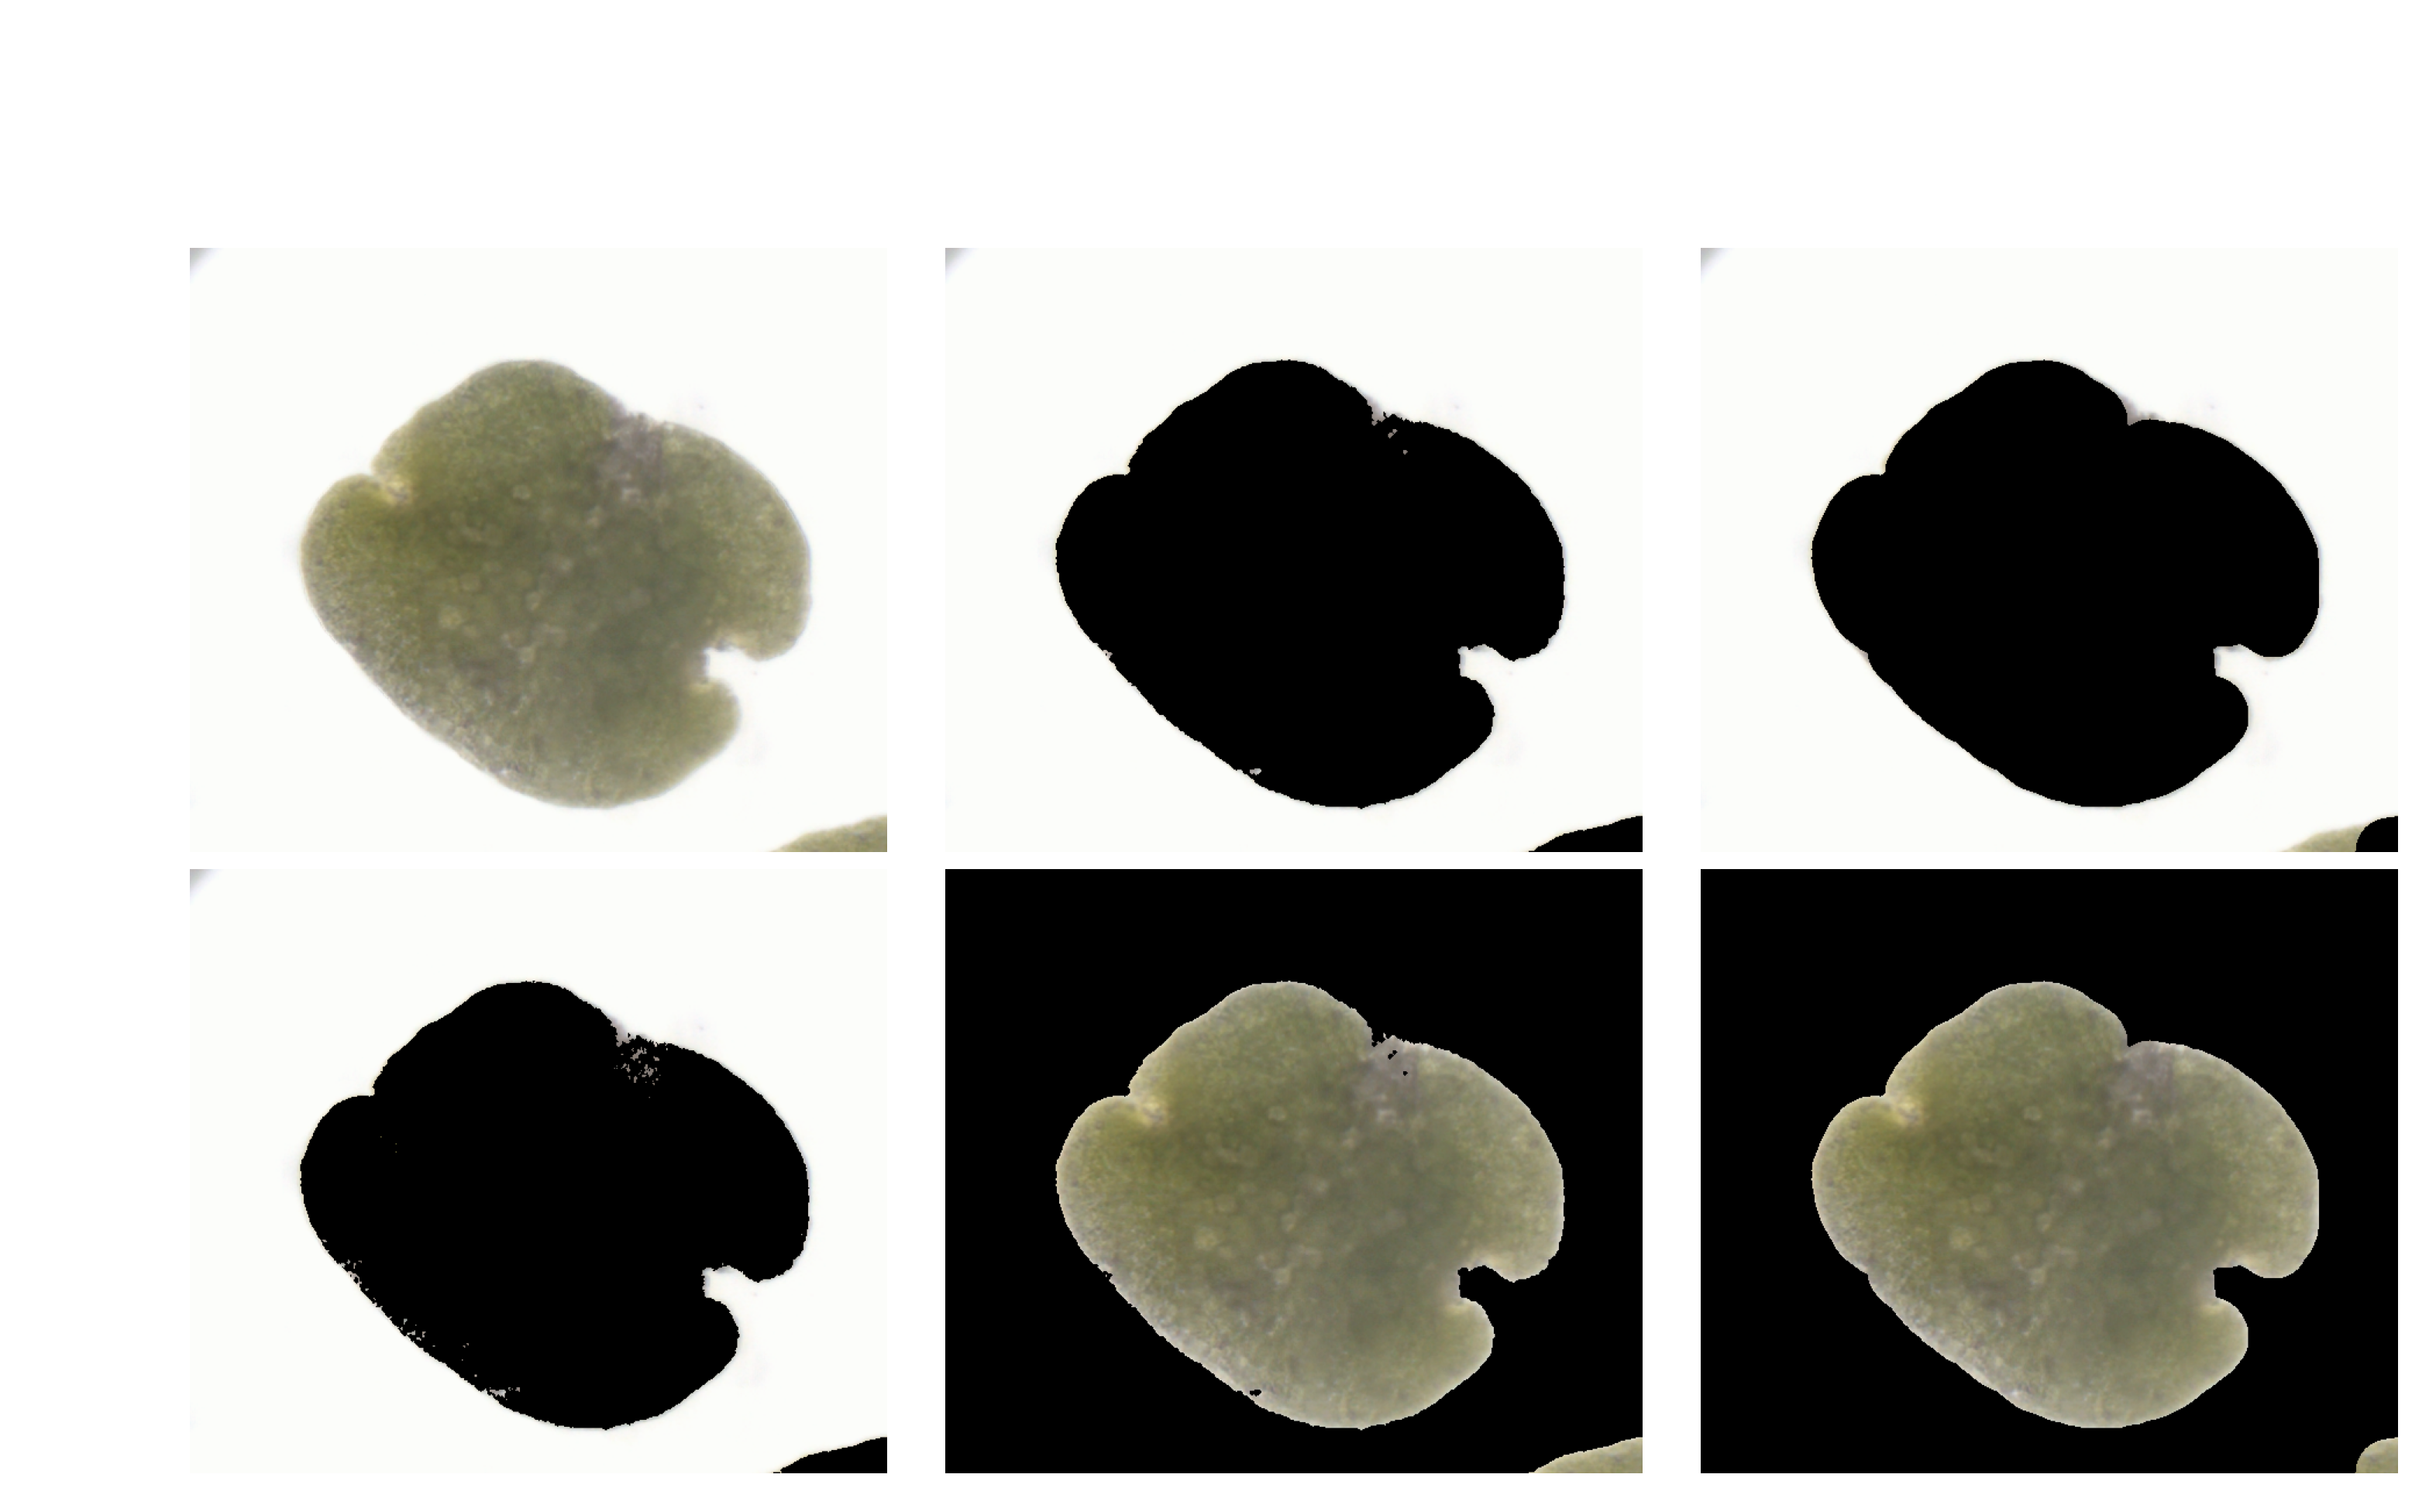


Binarization done for 61/61 images             
Processing PPG2 :
Binarization done for 61/61 images             
Processing PPG3 :
Binarization done for 61/61 images             
Processing PPG4 :
Binarization done for 61/61 images             
Processing PPG5 :
Binarization done for 61/61 images             
Processing PPG6 :


IndexError: tuple index out of range

In [46]:

BinarizeAndFitArea('220531_Ct1',StackList220531_Ct1,P220531_Ct1,Scale220531,FPH220531,Delay220531,0.98,'B',
                   showHist = True, debug = True, debuglist = [10,20,30],HSVrange =[(15, 15, 60),(70, 120,220)],fitwindow=10)

# BinarizeAndFitArea('220531_Ct2',StackList220531_Ct2,P220531_Ct2,Scale220531,FPH220531,Delay220531,0.98,'F',
#                    showHist = True, debug = False, debuglist = [10,20,30], HSVrange =[(15, 15, 60),(70, 140,220)],fitwindow=10)



# BinarizeAndFitOsChoc('220531_Ct1_Osmo',StackList220531_Ct1_Osmo,P220531_Ct1_Osmo,Scale220531_Osmo,FPH220531_Osmo,0.98,'F',
#                    showHist = True, debug = False, debuglist = [0], HSVrange =[(15, 15, 60),(70, 120,220)],
#                      FitIntervalComp = [0,22],FitIntervalRel = [25,51])

# BinarizeAndFitOsChoc('220531_Ct2_Osmo',StackList220531_Ct2_Osmo,P220531_Ct2_Osmo,Scale220531_Osmo,FPH220531_Osmo,0.98,'F',
#                    showHist = True, debug = False, debuglist = [0], HSVrange =[(15, 15, 60),(70, 120,220)],
#                      FitIntervalComp = [0,22],FitIntervalRel = [25,51])

## Test Zone

In [ ]:
# %run D:/Users/laplaud/Desktop/PostDoc/Code/JupyterNB/PropaguleAnalysis/2_AreaAnalysis.ipynb